In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

etfs = {
    "IWDA.L": "market",
    "ICLN": "clean_energy",
}

symbols = list(etfs.keys())

prices_daily = (yf.download(
    tickers=symbols, 
    progress=True
  )
  .dropna()
  )

returns_daily = (prices_daily
  .stack()
  .reset_index(level=1, drop=False)
  .reset_index()
  .rename(columns={
    "Date": "date",
    "Adj Close": "adjusted"}
  )
  # transform the Ticker column into a name column, using the etfs dictionary
  .assign(name = lambda x: x["Ticker"].map(etfs),
          ret=lambda x: x.groupby("name")["adjusted"].pct_change())
    .get(["name", "date", "ret"])
    .dropna()
)


(returns_daily
  .groupby("name")["ret"]
  .describe()
  .round(3)
)

[*********************100%%**********************]  2 of 2 completed


,count,mean,std,min,25%,50%,75%,max
name,,,,,,,,
clean_energy,3736.0,0.0,0.017,-0.128,-0.009,0.0,0.009,0.114
market,3736.0,0.0,0.010,-0.106,-0.003,0.0,0.005,0.085


In [ ]:
from plotnine import *
from mizani.formatters import date_format
from mizani.breaks import date_breaks

# Compute active returns as the difference between the ETF returns and the market returns
active_returns = (
    returns_daily
    .merge(
        returns_daily.query('name == "market"')[["date", "ret"]],
        on="date",
        suffixes=("", "_market"),
    )
    .assign(active_ret=lambda x: x["ret"] - x["ret_market"])
    .drop(columns=["ret_market"])
)

Price          name       date       ret  active_ret
0      clean_energy 2009-09-28  0.012636    0.012636
1            market 2009-09-28  0.000000    0.000000
2      clean_energy 2009-09-29 -0.008176   -0.006282
3            market 2009-09-29 -0.001893    0.000000
4      clean_energy 2009-09-30  0.008677    0.007348


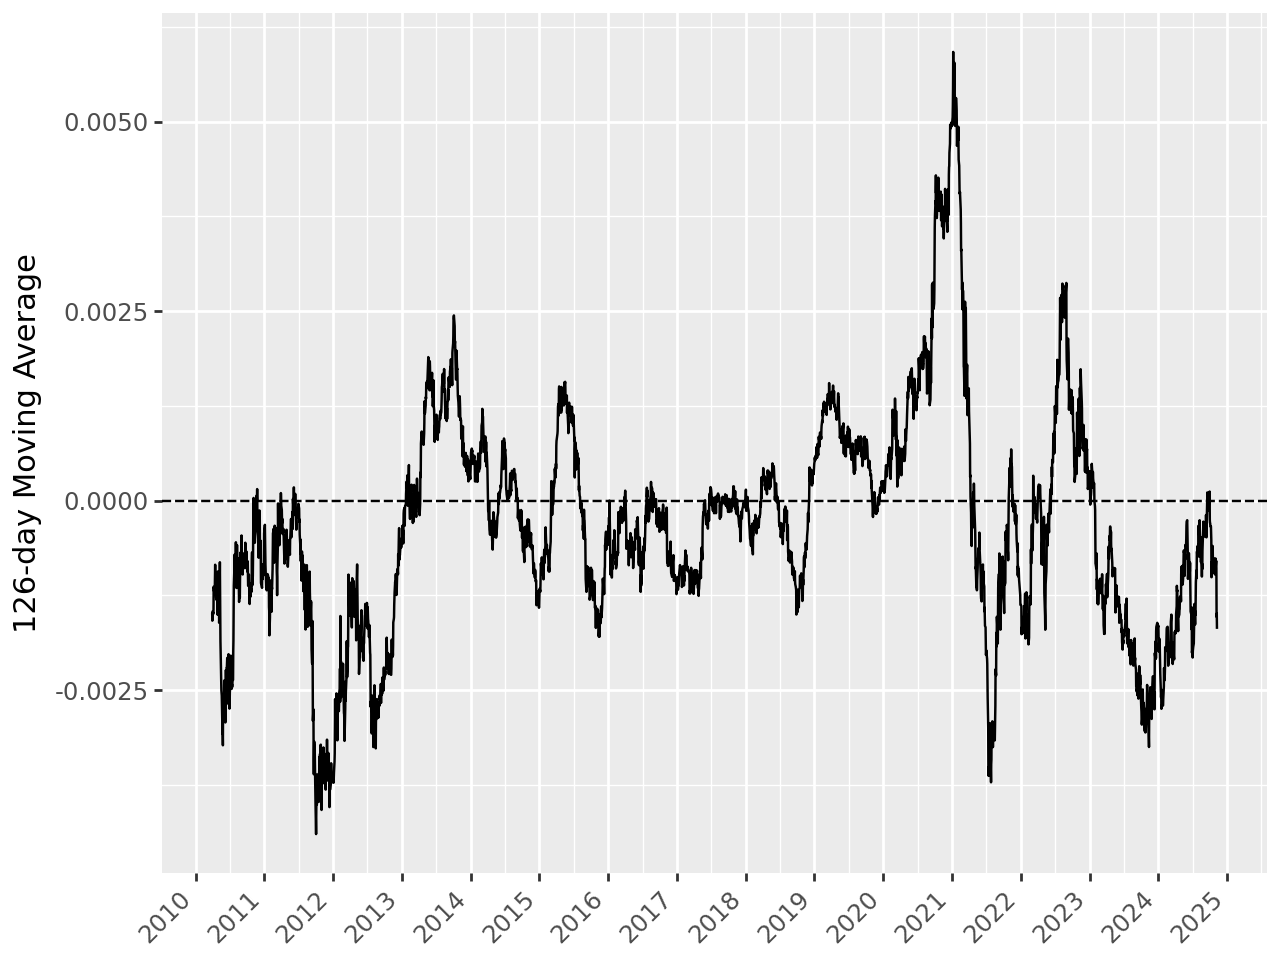

In [11]:
# 126 day moving average

# Compute the 126-day moving average of the active returns
active_returns_ma = (
    active_returns
    .assign(
        active_ret_ma=lambda x: x.groupby("name")["active_ret"].transform(
            lambda x: x.rolling(window=126).mean()
        )
    )
    .dropna(subset=["active_ret_ma"])
    .pivot(index="date", columns="name", values="active_ret_ma")
    .get(["clean_energy"])
)

# plot the the moving average, add a horizontal line at 0
plot_ma = (
    ggplot(active_returns_ma.reset_index(), aes(x="date", y="clean_energy"))
    + geom_line()
    + geom_hline(yintercept=0, linetype="dashed")
    + scale_x_datetime(breaks=date_breaks("1 year"), labels=date_format("%Y"))
    + labs(
        x="",
        y="126-day Moving Average",
        title="",
        color="Name",
    )
    + theme(axis_text_x=element_text(angle=45, hjust=1))
)

plot_ma.show()
